# CS280 Programming Assignment 2
__Implementing the Backpropagation Algorithm__<br>
<br>
Compiler: Python 3.6.5<br>
OS: Windows 7

## Import training and validation data

In [1]:
import numpy as np

In [2]:
train_data = np.genfromtxt('training_set.csv', delimiter=',')
train_labels = np.genfromtxt('training_labels.csv', delimiter=',')

validation_data = np.genfromtxt('validation_set.csv', delimiter=',')
validation_labels = np.genfromtxt('validation_labels.csv', delimiter=',')


In [3]:
def labels_to_onehotvector(labels):
    unique_labels, label_counts = np.unique(labels, return_counts=True)
    onehotvector = np.zeros((len(labels), len(unique_labels)))
    for index, label in enumerate(labels):
        onehotvector[int(index), int(label)-1] = int(1)
    return onehotvector

In [4]:
def onehotvectors_to_labels(onehotvectors):
    labels = np.zeros(onehotvectors.shape[0])
    for index, onehotvector in enumerate(onehotvectors):
        target_label = np.argwhere(onehotvector/np.max(onehotvector) == 1)
        labels[index] = target_label + 1 # +1 because there is no class 0
        #print('onehotvector[%d]='%(index), onehotvector)
        #print('labels[%d]=%d'%(index,labels[index]))
    return labels

In [5]:
train_labels = labels_to_onehotvector(train_labels)
validation_labels = labels_to_onehotvector(validation_labels)

In [6]:
train_data.shape, train_labels.shape, validation_data.shape, validation_labels.shape

((7674, 354), (7674, 8), (1910, 354), (1910, 8))

In [7]:
#train_data = np.array([[0, 0, 0],
#                       [0, 0, 1],
#                       [0, 1, 0],
#                       [0, 1, 1],
#                       [1, 0, 0],
#                       [1, 0, 1],
#                       [1, 1, 0],
#                       [1, 1, 1]])
#train_labels = np.array([[0, 0, 0],
#                       [1, 1, 0],
#                       [1, 0, 1],
#                       [0, 1, 1],
#                       [0, 1, 1],
#                       [1, 0, 0],
#                       [1, 1, 0],
#                       [0, 0, 0]])

## Define the Neural network
Define architecture of Neural Network

In [8]:
NUM_INPUT = train_data.shape[1]
NUM_HIDDEN1_NEURONS = 7
NUM_HIDDEN2_NEURONS = 5
NUM_OUTPUT = train_labels.shape[1]

Define the Learning Rate, LR:

In [9]:
LR = 0.1

Declare the matrices for the weights and biases, and then initialize them with random numbers:

In [10]:
def init_neurons(num_input, num_hidden1_neurons, num_hidden2_neurons, num_output):
    
    INIT_RANGE = 0.1

    x_in = np.zeros((num_input, 1))

    w_h1 = np.random.uniform(low=-INIT_RANGE, high=INIT_RANGE, size=(num_hidden1_neurons, num_input))
    b_h1 = np.random.uniform(low=-INIT_RANGE, high=INIT_RANGE, size=(num_hidden1_neurons, 1))

    w_h2 = np.random.uniform(low=-INIT_RANGE, high=INIT_RANGE, size=(num_hidden2_neurons, num_hidden1_neurons))
    b_h2 = np.random.uniform(low=-INIT_RANGE, high=INIT_RANGE, size=(num_hidden2_neurons, 1))

    w_out = np.random.uniform(low=-INIT_RANGE, high=INIT_RANGE, size=(num_output, num_hidden2_neurons))
    b_out = np.random.uniform(low=-INIT_RANGE, high=INIT_RANGE, size=(num_output, 1))

    d_out = np.zeros((num_output, 1))
    
    return x_in, w_h1, b_h1, w_h2, b_h2, w_out, b_out, d_out

Training Phase:

In [11]:
def predict(input_data, w_h1, b_h1, w_h2, b_h2, w_out, b_out):
    ##### FORWARD PASS #####
    ## HIDDEN LAYER 1
    v_h1 = np.dot(w_h1,input_data) + b_h1
    y_h1 = 1/(1 + np.exp(-v_h1))
    ## HIDDEN LAYER 2
    v_h2 = np.dot(w_h2, y_h1) + b_h2
    y_h2 = 1/(1 + np.exp(-v_h2))            
    ## OUTPUT LAYER
    v_out = np.dot(w_out, y_h2) + b_out
    out = 1/(1 + np.exp(-v_out))
    
    return out, y_h1, y_h2

In [12]:
def predict_batch(batch_data, w_h1, b_h1, w_h2, b_h2, w_out, b_out, labels=None):
    total_error = 0
    num_classes = b_out.shape[0]
    onehotvector_predictions = np.zeros((batch_data.shape[0], num_classes))
    for index, data in enumerate(batch_data):
        error = 0
        x_in = batch_data[index].reshape(-1, 1)
            
        out, dummy1, dummy2 = predict(x_in, w_h1, b_h1, w_h2, b_h2, w_out, b_out)
        #print('onehotvector_predictions[%d].shape='%(index), onehotvector_predictions[index].shape)
        #print('out.shape=', out.shape)
        onehotvector_predictions[index] = out.reshape(-1,)
        
        if labels is not None:
            d_out = labels[index].reshape(-1, 1)
            error = d_out - out
            total_error = total_error + np.sum(error*error)
    total_error *= (1/batch_data.shape[0])
    predictions = onehotvectors_to_labels(onehotvector_predictions)
    
    return total_error, predictions
    

In [ ]:
VALIDATION_PERIOD = 10
MAX_EPOCH = 30000

In [33]:
def train_fourlayer_neural_net(train_data, train_labels,num_input, num_hidden1_neurons,
                               num_hidden2_neurons, num_output, validation_data=None, validation_labels=None):
    
    train_time_start = time.time()
    report_time_start = time.time()
    
    # Print error report every __ epochs
    ERR_REPORT_PERIOD = 100 
    # Stop training if the current total training error goes below this value
    ERR_TERMINATION_COND = 0.0010000000000
    # stop training if the ratio of current validation error over the minimum validation error exceeds this value
    EARLY_STOPPING_VALERR_CRITERION = 8.0

    x_in, w_h1, b_h1, w_h2, b_h2, w_out, b_out, d_out = init_neurons(num_input,
                                                                     num_hidden1_neurons,
                                                                     num_hidden2_neurons,
                                                                     num_output)
    # Initialize
    total_error = np.ones((MAX_EPOCH, 1))
    total_validation_error = np.ones((int(MAX_EPOCH/VALIDATION_PERIOD), 1))
    training_ending_epoch = MAX_EPOCH-1
    epochs = range(0, MAX_EPOCH)
    
    for epoch_index in epochs:
        train_indices = np.random.permutation(train_data.shape[0])
        for train_index in train_indices:
            # READ DATA
            x_in = train_data[train_index].reshape(-1, 1)

            ##### FORWARD PASS #####
            out, y_h1, y_h2 = predict(x_in, w_h1, b_h1, w_h2, b_h2, w_out, b_out)
            
            ##### BACK PROPAGATION #####
            d_out = train_labels[train_index].reshape(-1, 1)
            error = d_out - out
            #print('\terror: ', error, '\n')
            delta_out = error*out*(1-out)
            #print('delta-out.shape=',delta_out.shape)
            #print('(1-y_h2).shape=',(1-y_h2).shape, ' y_h2*(1-y_h2).shape=', (y_h2*(1-y_h2)).shape, ' np.dot(w_out,delta_out).shape=', (np.dot(np.transpose(w_out),delta_out)).shape)
            delta_h2 = (y_h2*(1-y_h2))*(np.dot(np.transpose(w_out),delta_out))
            delta_h1 = (y_h1*(1-y_h1))*(np.dot(np.transpose(w_h2), delta_h2))

            ## Update the weights and biases
            w_out = w_out + LR*delta_out*np.transpose(y_h2)
            b_out = b_out + LR*delta_out
            
            w_h2 = w_h2 + LR*delta_h2*np.transpose(y_h1)
            b_h2 = b_h2 + LR*delta_h2
            
            w_h1 = w_h1 + LR*delta_h1*np.transpose(x_in)
            b_h1 = b_h1 + LR*delta_h1
            
            total_error[epoch_index] = total_error[epoch_index] + np.sum(error*error)
        
        total_error[epoch_index] *= (1/train_data.shape[0])
        
        current_valerror_index = int(epoch_index/VALIDATION_PERIOD)
        if validation_data is not None and epoch_index%VALIDATION_PERIOD == 0:
            total_validation_error[current_valerror_index], predictions = predict_batch(validation_data,
                                                                             w_h1, b_h1, w_h2,
                                                                             b_h2, w_out, b_out, validation_labels)
            
        valerr_ratio = total_validation_error[current_valerror_index]/min(total_validation_error)
            
        if epoch_index % ERR_REPORT_PERIOD == 0:
            report_time_end = time.time()
            print('\nEPOCH %d (duration: %3.4f seconds)'%(epoch_index, report_time_end - report_time_start))
            print('\ttraining error=%10.12f'%(total_error[epoch_index]))
            if validation_data is not None:
                print('\tvalidation_error=%10.12f (ratio=%10.12f)'% (total_validation_error[current_valerror_index], valerr_ratio))        
            report_time_start = time.time()
        
        if total_error[epoch_index] < 0.01:
            EARLY_STOPPING_VALERR_CRITERION = 4.0
        elif total_error[epoch_index] < 0.006:
            EARLY_STOPPING_VALERR_CRITERION = 1.3
            
        if (total_error[epoch_index] < ERR_TERMINATION_COND) or ((valerr_ratio) > EARLY_STOPPING_VALERR_CRITERION):
            training_ending_epoch = epoch_index
            current_valerror_index = int(training_ending_epoch/VALIDATION_PERIOD)
            break

    train_time_end = time.time()
    
    print('\n\n--\nTRAINING ENDED AT EPOCH %d (%3.3f s) WITH training_error=%10.12f'%(training_ending_epoch,
                                                                                      train_time_end-train_time_start,
                                                                                      total_error[training_ending_epoch]))
    print('\nTRAINING ENDED AT EPOCH %d WITH validation_error=%10.12f (min=%10.12f)'%(training_ending_epoch,
                                                                                      total_validation_error[current_valerror_index],
                                                                                      min(total_validation_error)))
    
    return w_h1, b_h1, w_h2, b_h2, w_out, b_out, total_error, total_validation_error, epochs, training_ending_epoch
        

        

In [34]:
import time
w_h1, b_h1, w_h2, b_h2, w_out, b_out, total_training_error, total_validation_error, epochs, training_ending_epoch = train_fourlayer_neural_net(train_data, train_labels,
                                                                                                                       NUM_INPUT, NUM_HIDDEN1_NEURONS,
                                                                                                                       NUM_HIDDEN2_NEURONS, NUM_OUTPUT,
                                                                                                                       validation_data, validation_labels)

from playsound import playsound
playsound('Victory.mp3')


EPOCH 0 (duration: 0.6080 seconds)
	training error=0.880506139186
	validation_error=0.873995924948 (ratio=1.000000000000)

EPOCH 100 (duration: 53.2450 seconds)
	training error=0.068388882591
	validation_error=0.066986047231 (ratio=1.000000000000)

EPOCH 200 (duration: 52.0504 seconds)
	training error=0.036838424389
	validation_error=0.047681369226 (ratio=1.064323061550)

EPOCH 300 (duration: 52.2705 seconds)
	training error=0.028402910837
	validation_error=0.060329065405 (ratio=1.679981947087)

EPOCH 400 (duration: 52.1584 seconds)
	training error=0.024353515876
	validation_error=0.029579249384 (ratio=1.000000000000)

EPOCH 500 (duration: 51.7674 seconds)
	training error=0.015976248090
	validation_error=0.066065869522 (ratio=2.501184776216)

EPOCH 600 (duration: 52.1004 seconds)
	training error=0.013377280230
	validation_error=0.025875626207 (ratio=1.000000000000)

EPOCH 700 (duration: 50.9872 seconds)
	training error=0.010827272829
	validation_error=0.034214183550 (ratio=1.373310788

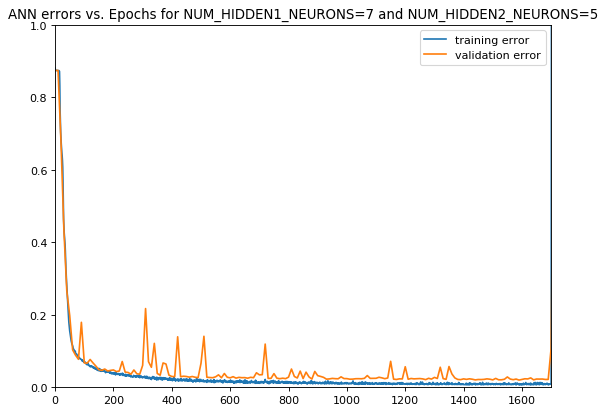

In [37]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(epochs, total_training_error, range(0, MAX_EPOCH, VALIDATION_PERIOD), total_validation_error)
plt.axis([0, training_ending_epoch, 0, max(np.max(total_training_error), np.max(total_validation_error))])
plt.legend(['training error', 'validation error'])
plt.title('ANN errors vs. Epochs for NUM_HIDDEN1_NEURONS=%d and NUM_HIDDEN2_NEURONS=%d'%(NUM_HIDDEN1_NEURONS, NUM_HIDDEN2_NEURONS))
plt.savefig('ANNerrors_%d_%d.png'%(NUM_HIDDEN1_NEURONS, NUM_HIDDEN2_NEURONS))
plt.show()